# 02 - Configuration and Coordinates

## Purpose

This tutorial explains two key components within SMPy:

1. **Configuration** controls reproducibility.
2. **Coordinate system choice** controls physical interpretation.

The notebook is intentionally short and conceptual.

## 1) Configuration Anatomy

Think of the config as a scientific contract:

- `general`: data source, coordinate system, output behavior
- `methods`: algorithm-specific parameters
- `plotting`: map rendering choices
- `snr`: null-realization controls

Every single tunable parameter in the model is defined in the configuration yaml file.

In [22]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import yaml

import smpy
from IPython.display import Image, display
from smpy.config import Config
from smpy.run import run

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "setup.py").exists() and (candidate / "smpy").is_dir():
            return candidate
    raise RuntimeError("Could not locate SMPy repository root.")


repo_root = find_repo_root(Path.cwd().resolve())
data_file = repo_root / "examples" / "data" / "forecast_lum_annular.fits"
artifacts_dir = repo_root / "examples" / "outputs" / "tutorials"
artifacts_dir.mkdir(parents=True, exist_ok=True)

print(f"Python package version: {smpy.__version__}")
print(f"Random seed: {SEED}")
print(f"Data file: {data_file}")
print(f"Artifacts: {artifacts_dir}")

Python package version: 0.5.0
Random seed: 42
Data file: /Users/vassig/research/SMPy/examples/data/forecast_lum_annular.fits
Artifacts: /Users/vassig/research/SMPy/examples/outputs/tutorials


In [23]:
config = Config.from_defaults("kaiser_squires")
config.update_from_kwargs(
    data=str(data_file),
    coord_system="radec",
    pixel_scale=0.4,
    g1_col="g1_Rinv",
    g2_col="g2_Rinv",
    weight_col="weight",
    mode=["E"],
    save_plots=False,
    save_fits=False,
    output_dir=str(artifacts_dir),
    output_base_name="tutorial02_minimal",
)
config.validate()

cfg = config.to_dict()
print("Validated config sections:", list(cfg.keys()))
print("Coordinate system:", cfg["general"]["coordinate_system"])
print("Method:", cfg["general"]["method"])

# Print the config in a readable format
print("\nConfiguration:")
for section, options in cfg.items():
    print(f"\n{section.capitalize()}:")
    for key, value in options.items():
        print(f"  {key}: {value}")


Validated config sections: ['general', 'methods', 'plotting', 'snr']
Coordinate system: radec
Method: kaiser_squires

Configuration:

General:
  input_path: /Users/vassig/research/SMPy/examples/data/forecast_lum_annular.fits
  input_hdu: 1
  output_directory: /Users/vassig/research/SMPy/examples/outputs/tutorials
  output_base_name: tutorial02_minimal
  coordinate_system: radec
  radec: {'resolution': 0.4, 'coord1': 'ra', 'coord2': 'dec'}
  pixel: {'downsample_factor': 1, 'coord1': 'X_IMAGE', 'coord2': 'Y_IMAGE', 'pixel_axis_reference': 'catalog'}
  g1_col: g1_Rinv
  g2_col: g2_Rinv
  weight_col: weight
  method: kaiser_squires
  create_snr: False
  create_counts_map: False
  overlay_counts_map: False
  mode: ['E']
  print_timing: False
  save_fits: False
  save_plots: False
  _coord_system_set_by_user: True
  _pixel_scale_set_by_user: True

Methods:
  kaiser_squires: {'smoothing': {'type': 'gaussian', 'sigma': 2.0}}
  aperture_mass: {'filter': {'type': 'schirmer', 'scale': 60, 'trunca

## 2) Reproducibility Essentials

Good baseline practice:

- Save the exact config used for a run.
- Keep output names stable and explicit.
- Log package versions and seed.

In [24]:
minimal_config_path = artifacts_dir / "config_minimal.yaml"
config.save_config(minimal_config_path)

reloaded = Config.from_file(minimal_config_path)
reloaded.validate()

print(f"Saved and reloaded: {minimal_config_path}")
print("Reloaded coordinate system:", reloaded.to_dict()["general"]["coordinate_system"])

Configuration saved to: /Users/vassig/research/SMPy/examples/outputs/tutorials/config_minimal.yaml
Saved and reloaded: /Users/vassig/research/SMPy/examples/outputs/tutorials/config_minimal.yaml
Reloaded coordinate system: radec


## 3) Coordinate Systems: How to Choose

Use this quick rule:

| Data columns look like | Use | Main scale knob |
|---|---|---|
| `ra`, `dec` in sky coordinates | `radec` | `pixel_scale` (arcmin/pixel) |
| detector/image coordinates (`X_*`, `Y_*`) | `pixel` | `downsample_factor` |

Important distinction:

- `pixel_scale` sets angular map resolution in sky coordinates.
- `downsample_factor` coarsens a native pixel-coordinate grid.

In [25]:
def make_base_config(output_base_name: str) -> Config:
    c = Config.from_defaults("kaiser_squires")
    c.update_from_kwargs(
        data=str(data_file),
        g1_col="g1_Rinv",
        g2_col="g2_Rinv",
        weight_col="weight",
        mode=["E"],
        save_plots=True,
        save_fits=False,
        output_dir=str(artifacts_dir),
        output_base_name=output_base_name,
    )
    return c


# RA/Dec configuration
radec_config = make_base_config("tutorial02_radec")
radec_config.update_from_kwargs(coord_system="radec", pixel_scale=0.4)
radec_config_path = artifacts_dir / "config_radec.yaml"
radec_config.save_config(radec_config_path)
radec_result = run(radec_config)

# Pixel configuration (explicitly map coordinate column names)
pixel_config = make_base_config("tutorial02_pixel")
pixel_config.update_from_kwargs(coord_system="pixel", downsample_factor=170)
pixel_dict = pixel_config.to_dict()
pixel_dict["general"]["pixel"]["coord1"] = "X_IMAGE_se"
pixel_dict["general"]["pixel"]["coord2"] = "Y_IMAGE_se"
pixel_config = Config(pixel_dict)
pixel_config.validate()
pixel_config_path = artifacts_dir / "config_pixel.yaml"
pixel_config.save_config(pixel_config_path)
pixel_result = run(pixel_config)

print("RA/Dec map shape:", radec_result["maps"]["E"].shape)
print("Pixel map shape:", pixel_result["maps"]["E"].shape)

Configuration saved to: /Users/vassig/research/SMPy/examples/outputs/tutorials/config_radec.yaml
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial02_radec_kaiser_squires_e_mode.png
Configuration saved to: /Users/vassig/research/SMPy/examples/outputs/tutorials/config_pixel.yaml
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial02_pixel_kaiser_squires_e_mode.png
RA/Dec map shape: (38, 57)
Pixel map shape: (38, 57)


In [26]:
rows = []
for label, res, cfg in [
    ("radec", radec_result, radec_config.to_dict()),
    ("pixel", pixel_result, pixel_config.to_dict()),
]:
    e = res["maps"]["E"]
    if label == "radec":
        scale_value = cfg["general"]["radec"]["resolution"]
        scale_label = "pixel_scale_arcmin"
    else:
        scale_value = cfg["general"]["pixel"]["downsample_factor"]
        scale_label = "downsample_factor"

    rows.append(
        {
            "coordinate_system": label,
            "map_shape": f"{e.shape[0]}x{e.shape[1]}",
            scale_label: scale_value,
            "mean_E": float(np.nanmean(e)),
            "std_E": float(np.nanstd(e)),
            "min_E": float(np.nanmin(e)),
            "max_E": float(np.nanmax(e)),
        }
    )

summary = pd.DataFrame(rows)
summary_path = artifacts_dir / "geometry_comparison.csv"
summary.to_csv(summary_path, index=False)
summary

,coordinate_system,map_shape,pixel_scale_arcmin,mean_E,std_E,min_E,max_E,downsample_factor
0,radec,38x57,0.4,2.460328e-18,0.042876,-0.104254,0.165443,NaN
1,pixel,38x57,NaN,-4.100547e-19,0.043971,-0.108428,0.165440,170.0


SMPy plotter output files:
- RA/Dec map: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial02_radec_kaiser_squires_e_mode.png
- Pixel map: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial02_pixel_kaiser_squires_e_mode.png
- Summary table: /Users/vassig/research/SMPy/examples/outputs/tutorials/geometry_comparison.csv


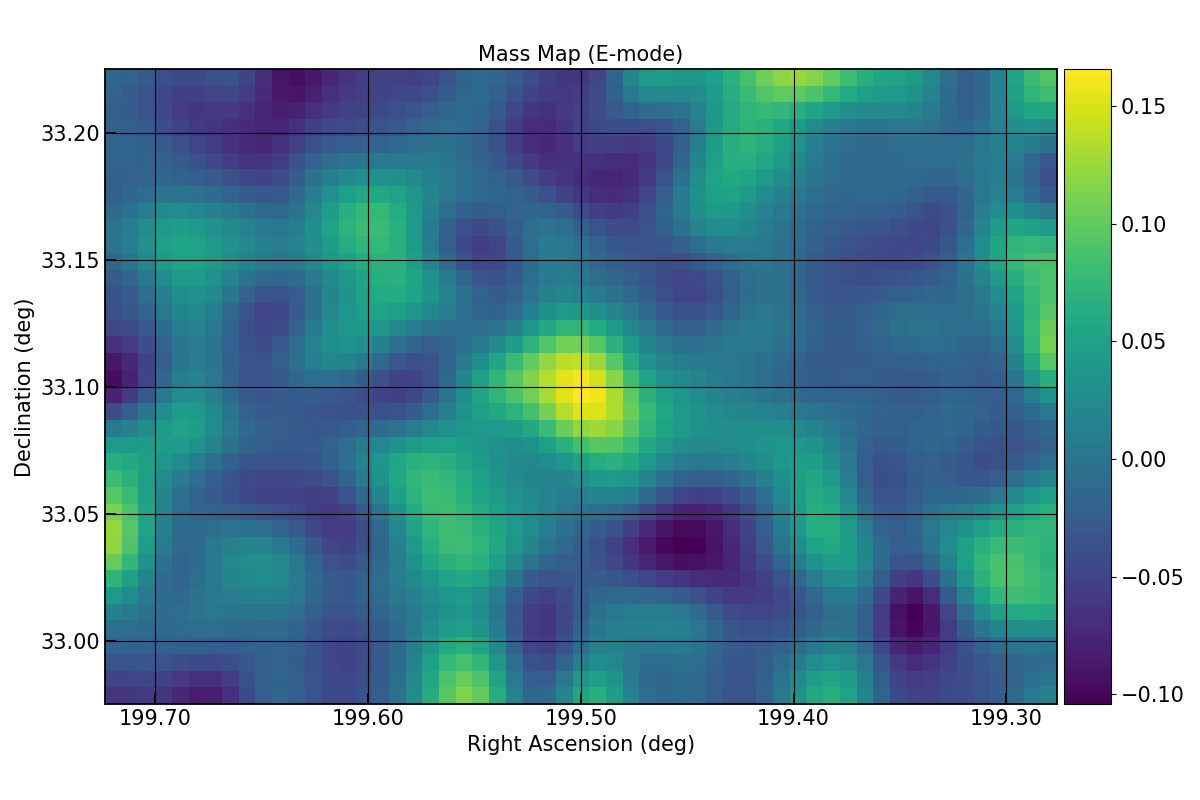

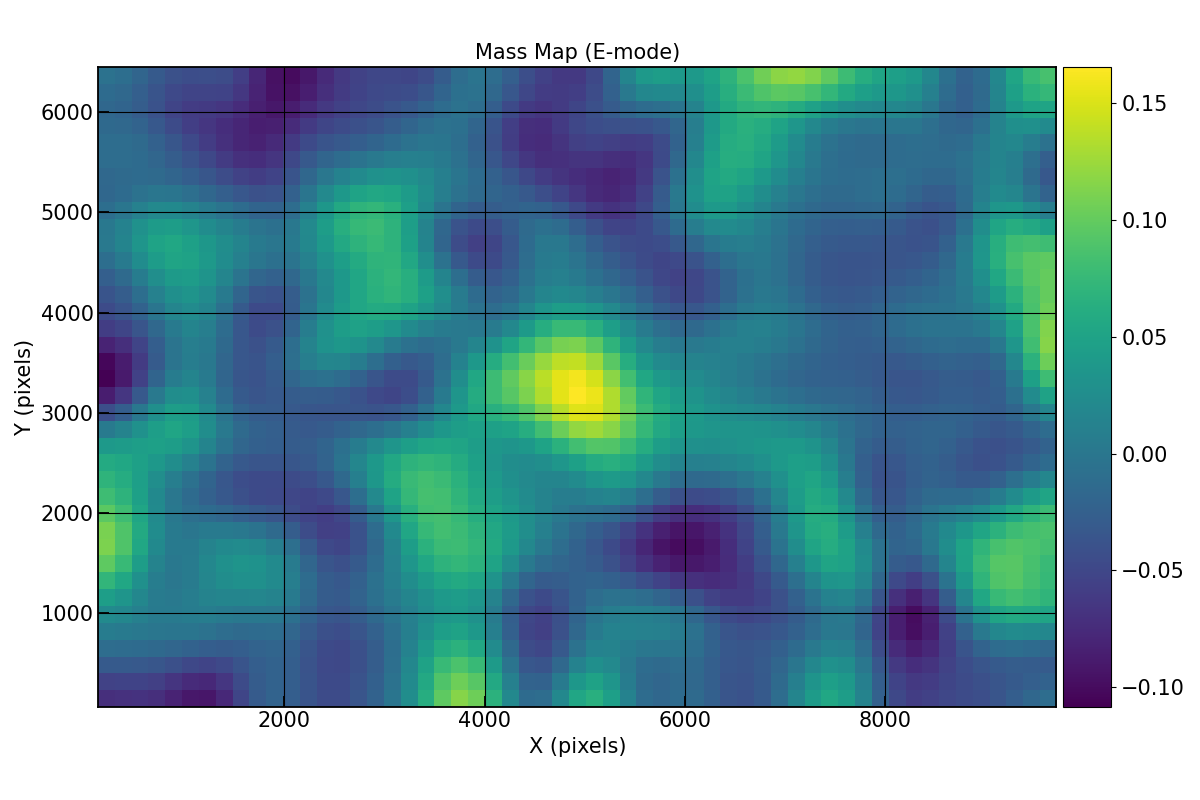

In [27]:
radec_png = (
    artifacts_dir
    / "kaiser_squires"
    / f"{radec_config.to_dict()['general']['output_base_name']}_kaiser_squires_e_mode.png"
)
pixel_png = (
    artifacts_dir
    / "kaiser_squires"
    / f"{pixel_config.to_dict()['general']['output_base_name']}_kaiser_squires_e_mode.png"
)

print("SMPy plotter output files:")
print(f"- RA/Dec map: {radec_png}")
print(f"- Pixel map: {pixel_png}")
print(f"- Summary table: {summary_path}")

if radec_png.exists() and pixel_png.exists():
    display(Image(filename=str(radec_png)))
    display(Image(filename=str(pixel_png)))
else:
    print("One or more expected PNG files were not found. Re-run the map cell above.")

## 4) Errors and Misconfigurations

When configuration and coordinate parameters disagree, SMPy fails fast. This is intentional!

In [28]:
bad_config = Config.from_defaults("kaiser_squires")
bad_config.update_from_kwargs(
    data=str(data_file),
    coord_system="radec",
    g1_col="g1_Rinv",
    g2_col="g2_Rinv",
    weight_col="weight",
)

try:
    bad_config.validate()
except ValueError as exc:
    print("Expected validation error:")
    print(exc)

Expected validation error:
Missing required parameter for coordinate_system='radec'. Provide 'pixel_scale' (API: pixel_scale=..., YAML: general.radec.resolution).


## 5) Practical Checklist

Before running:

1. Confirm your coordinate columns match your chosen coordinate system (and data/file format).
2. For `radec`, set `pixel_scale` in arcmin/pixel.
3. For `pixel`, set `downsample_factor` and pixel coordinate column names.
4. Save your config with the run outputs.